TODO
- label smoothing
- calculate average number of pad/unkown tokens used
- generate forever from list

# Boilerplate

In [1]:
import sys; sys.path.insert(0, '..')

In [2]:
# more configs for training are defined later
TRAINING_DIRECTORY = '../data/preprocessed_stories'
EXTENSION = '.clean'
N_TRAIN_FILES = 100000
N_TEST_FILES = 500
TOKENS_PER_BATCH = 4096
BPE_MODEL_FILE = 'summarizer.model'
BPE_VOCAB_FILE = 'summarizer.vocab'

In [3]:
# # show tensor2tensor hparams for summarization for reference
# import tensor2tensor.models.transformer
# from tensor2tensor.utils.registry import hparams
# params = hparams('transformer_prepend')()
# for k, v in sorted(vars(params).items(), key=lambda tup: tup[0]):
#     if not k.startswith('_') and not callable(v):
#         print(f'{k}={v!r}')

# Read in files

In [4]:
import glob

In [5]:
FILES = glob.glob('%s/*%s' % (TRAINING_DIRECTORY, EXTENSION))
print(len(FILES))
FILES[:10]

312085


['../data/preprocessed_stories/000064fee589e5607c1534a69f852d37b4936cca.clean',
 '../data/preprocessed_stories/0000800d9058217f6509d7e63ad475e2de0da611.clean',
 '../data/preprocessed_stories/0000bf554ca24b0c72178403b54c0cca62d9faf8.clean',
 '../data/preprocessed_stories/0000dfd9f52a470b9f29957686c2704b68cd0635.clean',
 '../data/preprocessed_stories/000128cbd36642ced67ac90bd7d4d1dd5e8cf554.clean',
 '../data/preprocessed_stories/0001d1afc246a7964130f43ae940af6bc6c57f01.clean',
 '../data/preprocessed_stories/0001d4ce3598e37f20a47fe609736f72e5d73467.clean',
 '../data/preprocessed_stories/0001dc22494415d03319a6833a00cd9c559f1395.clean',
 '../data/preprocessed_stories/0001f1fcec4ca8bc7e278607ba0e31e5cc046e66.clean',
 '../data/preprocessed_stories/0002067d13d3ca304e0bc98d04dde85d4091c55e.clean']

In [6]:
TRAIN_FILES = FILES[:N_TRAIN_FILES]
TEST_FILES = FILES[N_TRAIN_FILES:N_TRAIN_FILES+N_TEST_FILES]

# Define batch generator

# Initialize Tokenizer

In [7]:
import numpy as np
import sentencepiece as spm

class BytePairEncoder:
    def __init__(self, vocab_size, model_name, *, model_file=None, vocab_file=None,
                 training_file=None, processor=None, **kwargs):
        self.vocab_size = vocab_size
        self.model_name = model_name
        self.training_file = training_file
        self.model_file = f'{self.model_name}.model' if model_file is None else model_file
        self.vocab_file = f'{self.model_name}.vocab' if vocab_file is None else vocab_file
        if processor is None:
            if training_file is None:
                raise ValueError('training_file cannot be None when processor is also None.')
            processor = self._fit(input=training_file, vocab_size=vocab_size,
                                  model_prefix=model_name, model_type='bpe',
                                  **kwargs)
        self.processor = processor
        
    def encode(self, text):
        return np.array(self.processor.EncodeAsIds(text))
    
    def encode_as_pieces(self, text):
        return self.processor.EncodeAsPieces(text)
    
    def decode(self, ids):
        return self.processor.DecodeIds(ids.tolist())
    
    def decode_pieces(self, pieces):
        return self.processor.DecodePieces(pieces)

    @classmethod
    def from_files(cls, model_file, vocab_file):
        model_name = model_file.partition('.')[0]
        processor = cls._load_model(model_file)
        for vocab_size, _ in enumerate(open(vocab_file), start=1): pass
        return cls(vocab_size=vocab_size, model_name=model_name, processor=processor,
                   model_file=model_file, vocab_file=vocab_file)
        
    @staticmethod
    def _load_model(filename):
        processor = spm.SentencePieceProcessor()
        processor.Load(filename)
        return processor
        
    def _fit(self, **kwargs):
        params = ' '.join([f'--{k}={v}' for k, v in kwargs.items()])
        spm.SentencePieceTrainer.Train(params)
        processor = self._load_model(self.model_file)
        return processor

In [8]:
# trained in byte-pair-encoding
TOKENIZER = BytePairEncoder.from_files('summarizer.model', 'summarizer.vocab')

In [9]:
TOKENIZER.vocab_size

30000

# Tokenize files

In [10]:
class TrainingExample:
    """Simple container to keep track of training data. Useful for debugging."""
    def __init__(self, item, context_text, target_text, context_tokens,
                 target_tokens, filename):
        self.item = item
        self.context_text = context_text
        self.target_text = target_text
        self.context_tokens = context_tokens
        self.target_tokens = target_tokens
        self.filename = filename
        
    def __len__(self):
        return len(self.context_tokens) + len(self.target_tokens)

def load_files(files, tokenizer):
    """Load and tokenize files."""
    training_examples = []
    for file in files:
        with open(file) as f:
            context_text, target_text = f.read().split('\t')
        context_tokens = tokenizer(context_text)
        target_tokens = tokenizer(target_text)
        example = TrainingExample(file, context_text, target_text,
                                  context_tokens, target_tokens,
                                  file)
        training_examples.append(example)
    return training_examples

In [11]:
%%time
from tqdm import tqdm_notebook as tqdm
TRAINING_EXAMPLES = load_files(tqdm(TRAIN_FILES[:1000]), TOKENIZER.encode)
# sort files by number of tokens to reduce padding
TRAINING_EXAMPLES = sorted(TRAINING_EXAMPLES, key=lambda x: len(x))

HBox(children=(IntProgress(value=0, max=1000), HTML(value='')))


CPU times: user 3.74 s, sys: 113 ms, total: 3.85 s
Wall time: 3.97 s


In [12]:
[len(x) for x in TRAINING_EXAMPLES]

[28,
 134,
 147,
 171,
 176,
 181,
 182,
 204,
 209,
 220,
 224,
 237,
 238,
 240,
 240,
 251,
 255,
 256,
 260,
 266,
 266,
 276,
 277,
 279,
 279,
 284,
 286,
 290,
 297,
 298,
 299,
 300,
 300,
 306,
 310,
 314,
 316,
 324,
 327,
 328,
 328,
 331,
 334,
 339,
 340,
 340,
 342,
 345,
 345,
 353,
 360,
 361,
 361,
 362,
 368,
 368,
 371,
 371,
 373,
 373,
 373,
 374,
 375,
 375,
 375,
 376,
 377,
 378,
 379,
 380,
 380,
 382,
 383,
 386,
 388,
 388,
 390,
 391,
 392,
 392,
 394,
 395,
 395,
 396,
 396,
 396,
 397,
 400,
 401,
 401,
 408,
 408,
 408,
 409,
 412,
 419,
 419,
 420,
 421,
 424,
 426,
 427,
 427,
 428,
 428,
 428,
 428,
 430,
 431,
 432,
 438,
 438,
 439,
 440,
 442,
 443,
 443,
 444,
 445,
 445,
 446,
 446,
 446,
 447,
 449,
 451,
 453,
 453,
 454,
 454,
 455,
 459,
 460,
 461,
 461,
 463,
 466,
 470,
 470,
 471,
 472,
 476,
 476,
 478,
 479,
 479,
 481,
 482,
 482,
 482,
 483,
 486,
 489,
 490,
 490,
 492,
 496,
 497,
 499,
 499,
 499,
 499,
 500,
 501,
 501,
 503,
 503,

# Take a look at batches

In [13]:
import numpy as np
from data import BaseBatchGenerator
from keras.preprocessing.sequence import pad_sequences


class SummaryBatchGenerator(BaseBatchGenerator):
    def __init__(self, max_context_len=None, max_target_len=None, pad_token=0,
                 bos_token=1, eos_token=2, prepend=False):
        self.max_context_len = max_context_len
        self.max_target_len = max_target_len
        self.bos_token = bos_token
        self.eos_token = eos_token
        self.pad_token = pad_token
        self.prepend = prepend

    def generate_steps(self, item):
        example = item  # alias
        if self.max_target_len is not None \
                and len(example.target_tokens) > self.max_target_len:
            return []
        if self.max_context_len is not None:
            encoder_tokens = example.context_tokens[:self.max_context_len]
        else:
            encoder_tokens = example.context_tokens
        if self.prepend:
            decoder_tokens = np.append(example.context_tokens, self.eos_token)
        else:
            decoder_tokens = np.array([])
        decoder_tokens = np.append(decoder_tokens, example.target_tokens)
        decoder_tokens = np.append(decoder_tokens, self.eos_token)
        training_step = encoder_tokens, decoder_tokens, len(example)
        return [training_step]

    def generate_batches(self, steps, batch_size):
        batches = []
        min_batch_size = 0.95 * batch_size
        max_batch_size = 1.05 * batch_size
        step_sizes = [size for _, _, size in steps]
        current_batch_x1s = []
        current_batch_x2s = []
        items = enumerate(zip(steps, step_sizes, step_sizes[1:]))
        max_used_i = -1
        for i, (step, step_size, next_step_size) in items:
            if step_size > max_batch_size:
                print(f'skipping step with size {step_size}')
                continue
            encoder_tokens, decoder_tokens, _ = step
            current_batch_x1s.append(encoder_tokens)
            current_batch_x2s.append(decoder_tokens)
            next_batch_size = (len(current_batch_x1s) + 1) * next_step_size  # account for padding
            if next_batch_size > max_batch_size:
                max_used_i = i
                x1 = pad_sequences(current_batch_x1s, value=self.pad_token, padding='post')
                x2 = pad_sequences(current_batch_x2s, value=self.pad_token, padding='post')
                X = [x1, x2[:,:-1]]
                y = x2[:,1:]
                batches.append((X, y))
                current_batch_x1s, current_batch_x2s = [], []
            # if there aren't enough steps left to create a full sized batch
            # then break, the leftover steps will be added to the next call
            # to generate_batches()
            if sum(step_sizes[i+1:]) < batch_size:
                break
        return (batches, steps[max_used_i+1:]) if max_used_i >= 0 else (batches, steps)


Using TensorFlow backend.


In [14]:
BATCH_GENERATOR = SummaryBatchGenerator(pad_token=TOKENIZER.vocab_size, prepend=True)

In [15]:
%%time
epoch_generator = BATCH_GENERATOR.generate_epoch(TRAINING_EXAMPLES, batch_size=TOKENS_PER_BATCH)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 8.82 µs


In [16]:
epoch = list(epoch_generator)

In [17]:
len(epoch)

244

In [18]:
sum(x1.shape[0] for (x1, _), _ in epoch), len(TRAINING_EXAMPLES)

(999, 1000)

In [19]:
# TOOD: if we skip a training example because it is too large this will fail eroneously
# assert sum(x1.shape[0] for (x1, _), _ in epoch) == len(TRAINING_EXAMPLES), \
#    'number of steps in batch does not equal number of examples'

In [30]:
def view_training_steps(x1, x2, y):
    print(TOKENIZER.decode(x1[:np.argmax(x1 == 30_000)]))
    print('\n')
    print(TOKENIZER.decode(x2[:np.argmax(x2 == 30_000)]))
    print('\n')
    print(TOKENIZER.decode(y[:np.argmax(y == 30_000)]))

In [33]:
views = (view_training_steps(x1[0], x2[0], y[0]) for (x1, x2), y in epoch)

In [44]:
next(views)

A New York City mother died in the Catskills at the weekend after taking a strange fall from a ski lift. Police say that 44-year-old Olga Filkin, of Brooklyn, was riding the lift at Hunter Mountain alone when the incident occurred on Sunday afternoon. Filkin, described as a 'pretty good skier' and a regular at the resort, was on a trip with her husband and her daughter. She was on the D Lift alone when the three-person seat began to rock, according to The Times Union. Scene: Mother-of-two Olga Filkin fell 25 feet from a ski lift at Hunter Mountain ski resort in the Catskills on Sunday, after one of her skis became caught in a cable support pole, dragging her under the restraining bar Somehow, one of Filkin's skis became caught on one of the lift's cable support poles. Even though the restraint bar was down at the time - according to the vice president of the ski resort - Filkin was dragged under the bar and fell to the ground below. The mother-of-two fell 25 feet, according to NBC. She

In [45]:
(x1, x2), y = epoch[0]
print(x1.shape, x2.shape)
(x1, x2), y = epoch[-1]
print(x1.shape, x2.shape)

(16, 225) (16, 252)
(1, 2258) (1, 2295)


In [46]:
x1.shape, x2.shape

((1, 2258), (1, 2295))

In [47]:
import collections
def calc_stats(epoch, pad_token, unkown_token):
    stats = collections.defaultdict(int)
    for (x1, x2), y in epoch:
        stats['x1_tok'] += ((x1 != pad_token) & (x1 != unkown_token)).sum()
        stats['x1_pad'] += (x1 == pad_token).sum()
        stats['x1_unk'] += (x1 == unkown_token).sum()
        stats['x1_avg_seq_len'] += x1.shape[-1]
        stats['x2_tok'] += ((x2 != pad_token) & (x2 != unkown_token)).sum()
        stats['x2_pad'] += (x2 == pad_token).sum()
        stats['x2_unk'] += (x2 == unkown_token).sum()
        stats['x2_avg_seq_len'] += x2.shape[-1]
    stats['x1_avg_seq_len'] /= len(epoch)
    stats['x2_avg_seq_len'] /= len(epoch)
    return stats
calc_stats(epoch, BATCH_GENERATOR.pad_token, 0)

defaultdict(int,
            {'x1_avg_seq_len': 1098.0081967213114,
             'x1_pad': 9990,
             'x1_tok': 860513,
             'x1_unk': 1851,
             'x2_avg_seq_len': 1128.2131147540983,
             'x2_pad': 3399,
             'x2_tok': 895920,
             'x2_unk': 1895})

## Build final training generator
now that we're happy with the batch generator create one that goes forever

In [48]:
def generate_forever(items):
    while True:
        yield from items

In [49]:
TRAIN_GEN = generate_forever(epoch)

# Training

## Define functions for loss/metrics/callbacks

In [50]:
import tensorflow as tf
import keras.backend as K

# on custom implementation rather than keras see
# https://github.com/tensorflow/tensorflow/issues/17150
def sparse_categorical_crossentropy(y_true, y_pred):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

def perplexity(y_true, y_pred):
    cross_entropy = sparse_categorical_crossentropy(y_true, y_pred)
    return K.exp(cross_entropy)

In [51]:
import numpy as np

# see
# https://github.com/tensorflow/tensor2tensor/blob/master/tensor2tensor/utils/learning_rate.py
class LRScheduler:
    """Stateful learning rate scheduler.
    
    Useful if training is stopped and then resumed so that scheduling
    resumes considering the epoch during which training was interrupted.
    """
    def __init__(self, d_model, warmup_steps, learning_rate):
        self.d_model = d_model
        self.warmup_steps = warmup_steps
        self.learning_rate = learning_rate
        self.epoch = 1
        self.initial_lr = self.lr()

    def lr(self, *args):
        scalar = 5000 \
               * self.d_model**-0.5 \
               * min(self.epoch * self.warmup_steps**-1.5, self.epoch**-0.5)
        self.epoch += 1
        return 0.002 * scalar * self.learning_rate

## Define validation set

In [52]:
%%time
VALIDATION_EXAMPLES = load_files(tqdm(TEST_FILES[:1000]), TOKENIZER.encode)
# sort files by number of tokens to reduce padding
VALIDATION_EXAMPLES = sorted(VALIDATION_EXAMPLES, key=lambda x: len(x))
TEST_EPOCH = list(BATCH_GENERATOR.generate_epoch(VALIDATION_EXAMPLES, batch_size=TOKENS_PER_BATCH))
TEST_GEN = generate_forever(TEST_EPOCH)
N_VALIDATION_STEPS = BATCH_GENERATOR.batches_per_epoch(VALIDATION_EXAMPLES, batch_size=TOKENS_PER_BATCH)

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))


CPU times: user 2.09 s, sys: 110 ms, total: 2.2 s
Wall time: 2.29 s


## Training configs

In [53]:
from keras.optimizers import adam
from keras.callbacks import LearningRateScheduler, TensorBoard

In [54]:
# # model architecture
N_HEADS = 4
N_LAYERS = 4
D_MODEL = 64*N_HEADS
SENTENCE_LEN = None
VOCAB_SIZE = TOKENIZER.vocab_size + 1  # +1 accounts for pad token
DROPOUT = 0.1
OUTPUT_ACTIVATION = 'linear'  # temporary workaround for keras bug - see above

# learning rate
WARMUP_STEPS = 8_000
LEARNING_RATE = 0.2
LEARNING_RATE_SCHEDULER = LRScheduler(D_MODEL, WARMUP_STEPS, LEARNING_RATE)

# # optimization
# # https://arxiv.org/pdf/1804.00247.pdf
BETA_1 = 0.9
BETA_2 = 0.98
EPSILON = 1e-9
OPTIMIZER = adam(lr=LEARNING_RATE_SCHEDULER.initial_lr, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON)
METRICS = [sparse_categorical_crossentropy]
LOSS = perplexity

# # batch training
N_TRAIN_STEPS = 1_000
CALLBACKS = [LearningRateScheduler(LEARNING_RATE_SCHEDULER.lr),
             TensorBoard(log_dir='./logs')]

## Training

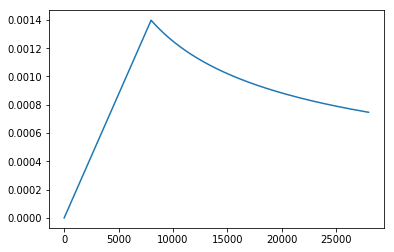

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
scheduler = LRScheduler(D_MODEL, WARMUP_STEPS, LEARNING_RATE)
learning_rates = [scheduler.lr()
                  for _ in range(WARMUP_STEPS+20_000)]
plt.plot(learning_rates)

In [ ]:
from model import Transformer
model = Transformer(
    n_heads=N_HEADS,
    encoder_layers=N_LAYERS,
    decoder_layers=N_LAYERS,
    d_model=D_MODEL,
    vocab_size=VOCAB_SIZE,
    sequence_len=SENTENCE_LEN,
    dropout=DROPOUT,
    output_activation=OUTPUT_ACTIVATION)

In [ ]:
model.summary()

In [ ]:
RUN_OPTS = tf.RunOptions(report_tensor_allocations_upon_oom=True)
TARGET_PLACEHOLDER = tf.placeholder(dtype='int32', shape=(None, SENTENCE_LEN))
model.compile(
    loss=LOSS,
    optimizer=OPTIMIZER,
    metrics=METRICS,
    target_tensors=[TARGET_PLACEHOLDER],
#    options=RUN_OPTS,
)

In [ ]:
# print loss values for reference
def display_loss_reference():
    format_ = 'perplexity: %20s\tentropy: %20s'
    upper_limit = np.log(VOCAB_SIZE)
    print(format_ % (np.exp(upper_limit), upper_limit))
    for i in reversed(range(int(np.floor(upper_limit))+1)):
        print(format_ % (np.exp(i), i))
display_loss_reference()

In [ ]:
model.fit_generator(
    TRAIN_GEN,
    steps_per_epoch=N_TRAIN_STEPS,
    validation_data=TEST_GEN,
    validation_steps=N_VALIDATION_STEPS,
    callbacks=CALLBACKS)